In [119]:
import time
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import DATASETS
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
from tqdm import tqdm
import pickle
import random
import numpy as np
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
import gensim.downloader
from torch import FloatTensor as FT

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline

plt.style.use('ggplot')

In [120]:
import torch
torch.cuda.is_available()


True

### Instructions
For this part, fill in the required code and make the notebook work. This wll be very similar to the Skip-Gram model, but a little more difficult. Look for the """ FILL IN """ string to guide you.

In [121]:
# Where do I want to run my job. You can do "cuda" on linux machines.
DEVICE = "mps" if torch.backends.mps.is_available() else  "cpu"
# The batch size in Adam or SGD.
BATCH_SIZE = 512
# Number of epochs.
NUM_EPOCHS = 10
# Predict from 2 words the inner word for CBOW.
# I.e. I'll have a window like ["a", "b", "c"] of continuous text (each is a word).
# We'll predict each of wc = ["a", "c"] from "b" = wc for Skip-Gram.
# For CBOW, we'll use ["a", "c"] to predict "b" = wo.
WINDOW = 1

# Negative samples.
K = 4

The text8 Wikipedia corpus. 100M characters.

In [122]:
!du -h text8

'du' is not recognized as an internal or external command,
operable program or batch file.


In [123]:
f = open('text8', 'r')
text = f.read()
# One big string of size 100M.
print(len(text))

100000000


In [124]:
punc = '!"#$%&()*+,-./:;<=>?@[\\]^_\'{|}~\t\n'

# Can do regular expressions here too.
for c in punc:
    if c in text:
        text.replace(c, ' ')

In [125]:
# A very crude tokenizer you get for free: lower case and also split on spaces.
TOKENIZER = get_tokenizer("basic_english")

In [126]:
words = TOKENIZER(text)
f = Counter(words)

In [127]:
len(words)

17005207

In [128]:
# Do a very crude filter on the text which removes all very popular words.
text = [word for word in words if f[word] > 5]

In [129]:
text[0:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [130]:
VOCAB = build_vocab_from_iterator([text])

In [131]:
# word -> int hash map.
stoi = VOCAB.get_stoi()
# int -> word hash map.
itos = VOCAB.get_itos() 

In [132]:
stoi['as']

11

In [133]:
# Total number of words.
len(stoi)

63641

In [134]:
f = Counter(text)
# This is the probability that we pick a word in the corpus.
z = {word: f[word] / len(text) for word in f}

In [135]:
threshold = 1e-5
# Probability that word is kept while subsampling.
# This is explained here and sightly differet from the paper: http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
p_keep = {word: (np.sqrt(z[word] / 0.001) + 1)*(0.0001 / z[word]) for word in f}

In [136]:
# This is in the integer space.
train_dataset = [word for word in text if random.random() < p_keep[word]]

# Rebuild the vocabulary.
VOCAB = build_vocab_from_iterator([train_dataset])

In [137]:
len(train_dataset)

7845468

In [138]:
# word -> int mapping.
stoi = VOCAB.get_stoi()
# int -> word mapping.
itos = VOCAB.get_itos() 

In [139]:
# The vocabulary size after we do all the filters.
len(VOCAB)

63641

In [140]:
# The probability we draw something for negative sampling.
f = Counter(train_dataset)
p = torch.zeros(len(VOCAB))

# Downsample frequent words and upsample less frequent.
s = sum([np.power(freq, 0.75) for word, freq in f.items()])        

for word in f:
    p[stoi[word]] = np.power(f[word], 0.75) / s

In [141]:
# Map everything to integers.
train_dataset = [stoi[word] for word in text]

In [142]:
# This just gets the (wc, wo) pairs that are positive - they are seen together!
def get_tokenized_dataset(dataset, verbose=False):
    x_list = []
        
    for i, token in enumerate(dataset):
        m = 1
        
        # Get the left and right tokens.
        start = max(0,i-m)
        left_tokens = dataset[start:i]
        
        end = min(i+m,len(dataset)-1)
        right_tokens = dataset[i+1:end+1]
        
        # Check these are the same length, and if so use them to add a row of data. This should be a list like.
        # [a, c, b] where b is the center word.
        if len(left_tokens) == len(right_tokens):
            w_context = left_tokens + right_tokens
            
            wc = token
                        
            x_list.extend(
                [w_context + [wc]]
            )
            
    return x_list

In [143]:
train_x_list = get_tokenized_dataset(train_dataset, verbose=False)

In [144]:
pickle.dump(train_x_list, open('train_x_list.pkl', 'wb'))

In [145]:
train_x_list = pickle.load(open('train_x_list.pkl', 'rb'))

In [146]:
# These are (wc, wo) pairs. All are y = +1 by design.
train_x_list[:10]

[[5233, 11, 3083],
 [3083, 5, 11],
 [11, 163, 5],
 [5, 1, 163],
 [163, 3133, 1],
 [1, 49, 3133],
 [3133, 60, 49],
 [49, 137, 60],
 [60, 128, 137],
 [137, 741, 128]]

In [147]:
len(train_x_list)// BATCH_SIZE

32579

In [148]:
# The number of things of BATCH_SIZE = 512.
assert(len(train_x_list) // BATCH_SIZE == 32579)

### Set up the dataloader.

In [149]:
train_dl = DataLoader(
    TensorDataset(
        torch.tensor(train_x_list).to(DEVICE),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [150]:
for xb in train_dl:
    assert(xb[0].shape == (BATCH_SIZE, 3))
    break

### Words we'll use to asses the quality of the model ...

In [151]:
valid_ids = torch.tensor([
    stoi['money'],
    stoi['lion'],
    stoi['africa'],
    stoi['musician'],
    stoi['dance'],
])

### Get the model.

In [152]:
class CBOWNegativeSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWNegativeSampling, self).__init__()
        self.A = nn.Embedding(vocab_size, embed_dim) # Context vectors - center word.
        self.B = nn.Embedding(vocab_size, embed_dim) # Output vectors - words around the center word.
        self.init_weights()

    def init_weights(self):
        # Is this the best way? Not sure.
        initrange = 0.5
        self.A.weight.data.uniform_(-initrange, initrange)
        self.B.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        # N is the batch size.
        # x is (N, 3)
        
        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x[:,0:2], x[:,2]
                
        # Each of these is (N, 2, D) since each context has 2 word.
        # We want this to be (N, D) and this is what we get.
        
        # (N, 2, D)
        a = self.A(w_context)
        
        # (N, D)
        a_avg = torch.mean(a, dim=1)
        
        # Each of these is (N, D) since each target has 1 word.
        b = self.B(wc)
      
        # The product between each context and target vector. Look at the Skip-Gram code.
        # The logits is now (N, 1) since we sum across the final dimension.
        logits = torch.sum(a_avg*b, dim=1).to(DEVICE)
                
        return logits

In [153]:
@torch.no_grad()
def validate_embeddings(
    model,
    valid_ids,
    itos
):
    """ Validation logic """

    # We will use context embeddings to get the most similar words
    # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
    embedding_weights = model.A.weight
        
    normalized_embeddings = embedding_weights.cpu() / np.sqrt(
        np.sum(embedding_weights.cpu().numpy()**2, axis=1, keepdims=True)
    )

    # Get the embeddings corresponding to valid_term_ids
    valid_embeddings = normalized_embeddings[valid_ids, :]

    # Compute the similarity between valid_term_ids (S) and all the embeddings (V).
    # We do S x d (d x V) => S x D and sort by negative similarity.
    top_k = 10 # Top k items will be displayed.
    similarity = np.dot(valid_embeddings.cpu().numpy(), normalized_embeddings.cpu().numpy().T)

    # Invert similarity matrix to negative
    # Ignore the first one because that would be the same word as the probe word
    similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]

    # Print the output.
    for i, word_id in enumerate(valid_ids):
        # j >= 1 here since we don't want to include the word itself.
        similar_word_str = ', '.join([itos[j] for j in similarity_top_k[i, :] if j >= 1])
        print(f"{itos[word_id]}: {similar_word_str}")

    print('\n')

### Set up the model

In [154]:
LR = 10.0
NUM_EPOCHS = 10
EMBED_DIM = 300

In [155]:
model = CBOWNegativeSampling(len(VOCAB), EMBED_DIM).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# The learning rate is lowered every epoch by 1/10.
# Is this a good idea?
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

In [156]:
model

CBOWNegativeSampling(
  (A): Embedding(63641, 300)
  (B): Embedding(63641, 300)
)

In [157]:
validate_embeddings(model, valid_ids, itos)

money: thunderstorm, permutation, aileen, additionally, enthroned, usenet, ferrell, inverses, cryogenically, lfo
lion: hallucinogenic, clonaid, bouvier, thorton, disparaged, teixeira, complying, inputs, nagy, cremation
africa: moguls, foreknowledge, lamented, caria, lauren, greenhouse, marcionism, verbs, corrected, philanthropist
musician: detour, subsumed, jah, thebes, busing, crs, vigorous, doll, grisham, unaccented
dance: denys, azaria, rutland, retainer, widow, chronically, sapphires, flathead, duchenne, aaronic




### Train the model

In [158]:
ratios = []

def train(dataloader, model, optimizer, epoch):
    model.train()
    total_acc, total_count, total_loss, total_batches = 0, 0, 0.0, 0.0
    log_interval = 500
    
    for idx, x_batch in tqdm(enumerate(dataloader)):
        
        x_batch = x_batch[0]
                
        batch_size = x_batch.shape[0]
        
        # Zero the gradient so they don't accumulate.
        optimizer.zero_grad()
        
        logits = model(x_batch)
                        
        # Get the positive samples loss. Notice we use weights here.
        positive_loss = torch.nn.BCEWithLogitsLoss()(input=logits, target=torch.ones(batch_size).to(DEVICE).float())
        
        # For each batch, get some negative samples.
        # We need a total of len(y_batch) * 2* WINDOW * K samples across a batch.
        # We then reshape this batch.
        # These are effectively the output words.
        
        negative_samples = torch.multinomial(p, batch_size * K, replacement=True)
        # print("negative_samples", negative_samples.size())

        # Context words are 2m things, m = 1 so w_context is (N, 2) while wc is (N, 1)
        w_context, wc = x_batch[:,0:2].to('cpu'), negative_samples 
        # print("w_context", w_context.size())
        # print("wc", wc.size())

        """
        if w_context looks like below (batch_size = 3)
        [
        (a, b),
        (c, d),
        (e, f)
        ] and K = 2 we'd like to get:
        
        [
        (a, b),
        (a, b),
        (c, d), 
        (c, d),
        (e, f),
        (e, f)
        ]
        
        This will be batch_size * K rows.
        """
        
        # This should be (N * K, 2)
        w_context = torch.concat([
            w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
        ])
        
        # Remove the last dimension 1.
        
        wc = wc.view(wc.size()[0],1)
        # print("w_context", w_context.size())
        # print("wc", wc.size())

        # Get the negative samples. This should be (N * K, 3).
        # Concatenate the w_context and wc along the column. Make sure everything is on CUDA / MPS or CPU.
        x_batch_negative = torch.cat([w_context, wc], axis = 1).to(DEVICE)
                
        """
        Note the way we formulated the targets: they are all 0 since these are negative samples.
        We do the BCEWithLogitsLoss by hand basically here.
        Notice we sum across the negative samples, per positive word.
        
        This is literally the equation in the lecture notes.
        """
        
        # (N, K, D) -> (N, D) -> (N)
        # Look at the Skip-Gram notebook.
        negative_loss = model(x_batch_negative).neg().sigmoid().log().reshape(
            batch_size, K
        ).sum(1).mean().neg().to(DEVICE)
        
        loss = (positive_loss + negative_loss).mean()
                
        # Get the gradients via back propagation. 
        loss.backward()
                        
        # Clip the gradients? Generally a good idea.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Used for optimization. This should be roughly 0.001, on average.
        # You can use this to see if your learning rate is right - you can also plot the loss performance.
        with torch.no_grad():
            r = [
                (LR * p.grad.std() / p.data.std()).log10().item() for _, p in model.named_parameters()
            ]
            ratios.append(r)  
        
        # Do an optimization step. Update the parameters A and B.
        optimizer.step()
        # Get the new loss.
        total_loss += loss.item()
        # Update the batch count.
        total_batches += 1
                
        if idx % log_interval == 0:
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f} ".format(
                    epoch,
                    idx,
                    len(dataloader),
                    total_loss / total_batches
                )
            )
            validate_embeddings(model, valid_ids, itos)
            total_loss, total_batches = 0.0, 0.0

### Some results from the run look like below:

Somewhere inside of 2 iterations you should get sensible associattions.
Paste here a screenshot of the closest vectors.

In [159]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    
    train(train_dl, model, optimizer, epoch)
    # We have a learning rate scheduler here.
    # Basically, given the state of the optimizer, this lowers the learning rate in a smart way.
    scheduler.step()

0it [00:00, ?it/s]C:\Users\Alex\AppData\Local\Temp\ipykernel_16884\973106114.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.repeat(K, 1) for w in torch.tensor(w_context).split(1)
1it [00:00,  1.12it/s]

| epoch   1 |     0/32580 batches | loss    4.059 
money: thunderstorm, permutation, aileen, additionally, enthroned, usenet, ferrell, inverses, cryogenically, lfo
lion: hallucinogenic, clonaid, bouvier, thorton, disparaged, teixeira, complying, inputs, nagy, cremation
africa: moguls, foreknowledge, lamented, caria, lauren, greenhouse, marcionism, verbs, corrected, philanthropist
musician: detour, subsumed, jah, thebes, busing, crs, vigorous, doll, grisham, unaccented
dance: denys, azaria, rutland, retainer, widow, chronically, sapphires, flathead, duchenne, aaronic




501it [01:16,  5.79it/s]

| epoch   1 |   500/32580 batches | loss    3.713 
money: thunderstorm, permutation, aileen, additionally, enthroned, ferrell, usenet, cryogenically, vallabhbhai, lfo
lion: hallucinogenic, clonaid, bouvier, thorton, disparaged, teixeira, complying, nagy, cremation, inputs
africa: moguls, foreknowledge, caria, lamented, greenhouse, lauren, verbs, marcionism, corrected, philanthropist
musician: detour, subsumed, thebes, jah, busing, crs, vigorous, grisham, doll, unaccented
dance: denys, azaria, widow, rutland, retainer, chronically, sapphires, flathead, aaronic, duchenne




1001it [02:31,  5.83it/s]

| epoch   1 |  1000/32580 batches | loss    3.354 
money: thunderstorm, aileen, permutation, additionally, enthroned, ferrell, cryogenically, usenet, vallabhbhai, lfo
lion: hallucinogenic, clonaid, bouvier, thorton, disparaged, teixeira, complying, nagy, cremation, fim
africa: foreknowledge, moguls, lauren, greenhouse, caria, verbs, lamented, resign, corrected, marcionism
musician: detour, subsumed, jah, thebes, busing, crs, vigorous, doll, grisham, lumley
dance: denys, widow, azaria, chronically, rutland, retainer, sapphires, flathead, aaronic, duchenne




1501it [03:45,  6.03it/s]

| epoch   1 |  1500/32580 batches | loss    3.025 
money: thunderstorm, aileen, additionally, permutation, enthroned, ferrell, vallabhbhai, cryogenically, usenet, freighter
lion: hallucinogenic, clonaid, bouvier, thorton, disparaged, teixeira, complying, nagy, solf, fim
africa: foreknowledge, moguls, lauren, greenhouse, verbs, lamented, syndicate, caria, corrected, sweetened
musician: detour, subsumed, thebes, jah, busing, crs, vigorous, lumley, which, grisham
dance: denys, azaria, widow, chronically, retainer, rutland, flathead, sapphires, duchenne, aaronic




2001it [04:59,  5.83it/s]

| epoch   1 |  2000/32580 batches | loss    2.791 
money: thunderstorm, additionally, aileen, permutation, ferrell, vallabhbhai, freighter, enthroned, usenet, cryogenically
lion: hallucinogenic, clonaid, bouvier, teixeira, thorton, disparaged, complying, solf, nagy, fim
africa: foreknowledge, greenhouse, verbs, lauren, moguls, lamented, syndicate, pc, resign, caria
musician: detour, subsumed, there, which, thebes, jah, in, busing, crs, b
dance: denys, widow, chronically, azaria, retainer, rutland, flathead, russa, sapphires, duchenne




2502it [06:14,  6.35it/s]

| epoch   1 |  2500/32580 batches | loss    2.622 
money: thunderstorm, additionally, aileen, permutation, ferrell, vallabhbhai, freighter, cryogenically, lfo, artie
lion: hallucinogenic, clonaid, bouvier, teixeira, disparaged, complying, thorton, solf, fim, nagy
africa: foreknowledge, verbs, greenhouse, moguls, lauren, pc, ouguiya, lamented, syndicate, scrupulously
musician: there, detour, which, subsumed, b, thebes, jah, that, used, his
dance: denys, widow, chronically, azaria, retainer, rutland, flathead, russa, duchenne, aaronic




3002it [07:26,  6.29it/s]

| epoch   1 |  3000/32580 batches | loss    2.488 
money: additionally, thunderstorm, aileen, permutation, ferrell, vallabhbhai, freighter, states, lfo, artie
lion: hallucinogenic, clonaid, bouvier, teixeira, complying, solf, disparaged, thorton, fim, nagy
africa: foreknowledge, verbs, greenhouse, lauren, pc, last, ouguiya, moguls, syndicate, than
musician: there, detour, which, b, used, called, his, most, subsumed, thebes
dance: denys, widow, chronically, azaria, retainer, flathead, aaronic, rutland, duchenne, sapphires




3501it [08:44,  5.58it/s]

| epoch   1 |  3500/32580 batches | loss    2.382 
money: additionally, states, thunderstorm, permutation, ferrell, aileen, vallabhbhai, freighter, may, if
lion: hallucinogenic, clonaid, bouvier, teixeira, solf, disparaged, complying, thorton, ren, wto
africa: foreknowledge, than, verbs, greenhouse, last, second, lauren, pc, used
musician: there, b, called, detour, used, most, which, use, same, it
dance: denys, chronically, widow, azaria, retainer, duchenne, aaronic, flathead, rutland, russa




4001it [10:01,  5.89it/s]

| epoch   1 |  4000/32580 batches | loss    2.289 
money: states, additionally, may, if, all, and, thunderstorm, but, ferrell, permutation
lion: hallucinogenic, clonaid, bouvier, teixeira, complying, disparaged, solf, thorton, fim, sanfl
africa: than, three, used, two, nine, some, last, it, second
musician: b, there, called, most, used, use, which, same, many, detour
dance: denys, chronically, widow, azaria, retainer, flathead, duchenne, aaronic, rutland, russa




4501it [11:18,  5.61it/s]

| epoch   1 |  4500/32580 batches | loss    2.217 
money: states, may, if, additionally, as, or, all, city, but, called
lion: hallucinogenic, clonaid, bouvier, teixeira, complying, disparaged, solf, thorton, fim, wings
africa: than, nine, three, used, two, eight, many, five, some
musician: there, b, called, use, used, most, same, often, which, his
dance: denys, chronically, widow, azaria, retainer, flathead, an, duchenne, aaronic, rutland




5001it [12:37,  5.55it/s]

| epoch   1 |  5000/32580 batches | loss    2.158 
money: states, but, all, called, if, may, as, both, or, city
lion: hallucinogenic, clonaid, bouvier, teixeira, solf, complying, disparaged, thorton, fim, wto
africa: nine, two, than, used, eight, zero, five, seven, three
musician: b, there, called, use, most, used, same, often, which, one
dance: denys, chronically, widow, azaria, an, retainer, duchenne, flathead, aaronic, counties




5501it [13:57,  5.67it/s]

| epoch   1 |  5500/32580 batches | loss    2.107 
money: states, but, called, all, or, which, if, name, both, used
lion: hallucinogenic, clonaid, bouvier, teixeira, solf, complying, disparaged, thorton, fim, wto
africa: seven, nine, used, two, five, than, eight, four, zero, all
musician: b, there, called, use, same, most, used, often, which, see
dance: denys, an, chronically, widow, azaria, retainer, article, duchenne, being, counties




6001it [15:14,  5.72it/s]

| epoch   1 |  6000/32580 batches | loss    2.058 
money: but, states, city, called, all, both, which, name, if, used
lion: hallucinogenic, clonaid, bouvier, teixeira, solf, complying, disparaged, thorton, fim, wings
africa: nine, seven, used, eight, five, four, than, six, one, two
musician: b, called, use, used, most, same, there, often, which, see
dance: an, denys, widow, chronically, article, azaria, retainer, being, duchenne, marriage




6501it [16:34,  5.49it/s]

| epoch   1 |  6500/32580 batches | loss    2.016 
money: but, states, called, both, city, used, name, if, all, which
lion: hallucinogenic, clonaid, bouvier, teixeira, solf, complying, disparaged, wings, wto, fim
africa: seven, nine, used, eight, five, city, four, six, than
musician: b, called, use, used, there, same, most, often, film, see
dance: an, article, widow, denys, being, chronically, azaria, marriage, years, counties




7002it [17:55,  6.21it/s]

| epoch   1 |  7000/32580 batches | loss    1.976 
money: but, both, states, called, used, all, if, city, name, up
lion: hallucinogenic, clonaid, bouvier, teixeira, solf, complying, disparaged, wings, wto, ren
africa: nine, eight, seven, used, five, city, than, three, six
musician: b, called, use, used, same, most, there, film, often, do
dance: an, article, being, widow, denys, years, chronically, marriage, actor, azaria




7501it [19:14,  5.43it/s]

| epoch   1 |  7500/32580 batches | loss    1.948 
money: both, states, but, called, used, if, all, there, city, known
lion: clonaid, hallucinogenic, teixeira, bouvier, complying, solf, wings, disparaged, ren, fim
africa: nine, eight, seven, used, city, five, three, zero, four
musician: called, b, used, use, same, there, film, most, see, do
dance: an, article, being, widow, years, actor, over, marriage, now, interest




8002it [20:34,  5.90it/s]

| epoch   1 |  8000/32580 batches | loss    1.915 
money: both, used, called, states, all, there, but, if, known, city
lion: hallucinogenic, clonaid, teixeira, bouvier, complying, solf, wings, ren, disparaged, fim
africa: nine, eight, seven, five, used, city, four, six, zero
musician: called, b, used, use, film, same, there, most, form, do
dance: an, article, being, years, actor, over, widow, country, considered, marriage




8501it [21:53,  5.61it/s]

| epoch   1 |  8500/32580 batches | loss    1.879 
money: both, used, but, states, called, known, if, name, there, all
lion: hallucinogenic, clonaid, teixeira, bouvier, complying, solf, ren, wings, disparaged, wto
africa: nine, eight, city, seven, used, five, six, government, part, zero
musician: called, b, use, used, film, same, form, there, do, united
dance: an, article, being, actor, country, interest, years, based, called, considered




9001it [23:10,  6.02it/s]

| epoch   1 |  9000/32580 batches | loss    1.858 
money: used, both, states, but, name, known, if, called, city, there
lion: hallucinogenic, clonaid, teixeira, bouvier, complying, solf, ren, wings, disparaged, fim
africa: city, nine, eight, five, used, seven, part, six, government, zero
musician: called, b, use, used, film, same, form, united, there, made
dance: an, article, actor, being, country, based, considered, god, interest, years




9502it [24:24,  6.27it/s]

| epoch   1 |  9500/32580 batches | loss    1.836 
money: used, both, but, if, name, states, known, called, up, city
lion: clonaid, hallucinogenic, teixeira, bouvier, solf, ren, complying, wings, effects, disparaged
africa: nine, city, eight, seven, five, used, six, part, government, zero
musician: called, b, use, used, film, same, form, united, do, made
dance: an, article, country, actor, being, god, considered, example, years, play




10002it [25:38,  6.39it/s]

| epoch   1 | 10000/32580 batches | loss    1.814 
money: used, both, if, but, states, called, name, city, known, them
lion: clonaid, hallucinogenic, teixeira, bouvier, effects, ren, solf, complying, wings, disparaged
africa: nine, city, eight, seven, part, five, used, six, government, zero
musician: called, b, use, film, used, form, same, united, made, known
dance: an, article, country, example, actor, play, interest, based, considered, god




10501it [26:49,  6.13it/s]

| epoch   1 | 10500/32580 batches | loss    1.794 
money: used, both, but, if, called, states, city, made, known, them
lion: clonaid, hallucinogenic, teixeira, effects, bouvier, ren, wings, solf, complying, disparaged
africa: nine, city, eight, seven, five, part, six, used, zero, god
musician: use, called, b, film, used, form, united, made, do, same
dance: an, country, article, example, actor, based, play, interest, considered, development




11002it [28:02,  6.25it/s]

| epoch   1 | 11000/32580 batches | loss    1.775 
money: used, but, made, both, called, name, known, if, states, them
lion: clonaid, hallucinogenic, effects, teixeira, wings, bouvier, ren, solf, complying, disparaged
africa: nine, city, seven, eight, five, part, used, six, zero, god
musician: use, called, b, film, used, form, united, made, do, history
dance: an, country, example, actor, play, article, interest, considered, based, god




11502it [29:15,  6.32it/s]

| epoch   1 | 11500/32580 batches | loss    1.758 
money: used, known, made, both, called, but, name, states, them, up
lion: clonaid, hallucinogenic, effects, teixeira, wings, ren, bouvier, solf, disparaged, complying
africa: nine, seven, eight, city, part, six, five, god, zero, used
musician: use, called, b, film, used, form, united, made, addition, do
dance: an, example, actor, country, interest, play, article, god, considered, usually




12002it [30:27,  6.28it/s]

| epoch   1 | 12000/32580 batches | loss    1.747 
money: used, known, but, both, made, name, them, called, states, well
lion: clonaid, hallucinogenic, effects, teixeira, wings, ren, bouvier, solf, brussels, pass
africa: nine, seven, eight, part, city, five, six, god, zero, end
musician: use, called, b, film, form, united, made, used, addition, do
dance: example, an, country, actor, play, interest, god, built, development, considered




12501it [31:44,  6.13it/s]

| epoch   1 | 12500/32580 batches | loss    1.723 
money: used, known, but, both, seen, made, them, called, name, said
lion: clonaid, hallucinogenic, effects, wings, teixeira, ren, solf, bouvier, brussels, pass
africa: nine, seven, part, eight, city, five, zero, end, god, six
musician: use, b, called, film, united, form, addition, used, made, history
dance: example, country, an, actor, interest, play, development, based, built, god




13001it [32:56,  5.53it/s]

| epoch   1 | 13000/32580 batches | loss    1.708 
money: used, both, known, but, made, them, called, said, seen, because
lion: clonaid, hallucinogenic, effects, wings, pass, teixeira, ren, brussels, solf, bouvier
africa: nine, seven, eight, part, city, end, five, six, u, zero
musician: use, b, called, form, film, addition, united, used, made, history
dance: example, country, development, an, interest, play, built, actor, based, god




13501it [34:11,  6.14it/s]

| epoch   1 | 13500/32580 batches | loss    1.694 
money: used, both, seen, said, made, known, but, called, able, them
lion: effects, clonaid, hallucinogenic, wings, pass, brussels, teixeira, ren, choose, style
africa: nine, part, seven, eight, end, city, five, six, zero, u
musician: use, form, called, addition, b, film, united, used, made, history
dance: example, country, an, development, interest, play, built, actor, god, based




14002it [35:23,  6.42it/s]

| epoch   1 | 14000/32580 batches | loss    1.687 
money: used, said, seen, known, created, both, them, able, called, made
lion: clonaid, effects, hallucinogenic, wings, pass, brussels, teixeira, ren, choose, kind
africa: nine, eight, part, seven, end, city, six, zero, u, five
musician: use, form, addition, called, b, united, made, film, actor, used
dance: example, country, play, actor, built, development, interest, based, battle, considered




14501it [36:34,  5.98it/s]

| epoch   1 | 14500/32580 batches | loss    1.674 
money: used, said, seen, created, but, known, order, able, called, both
lion: effects, clonaid, hallucinogenic, pass, wings, brussels, ren, choose, teixeira, kind
africa: nine, eight, part, seven, end, city, six, germany, zero, u
musician: use, form, addition, called, b, actor, united, made, considered, film
dance: country, example, play, actor, battle, considered, built, interest, development, based




15002it [37:46,  6.43it/s]

| epoch   1 | 15000/32580 batches | loss    1.663 
money: used, said, created, seen, known, both, order, able, called, development
lion: effects, clonaid, hallucinogenic, wings, pass, brussels, ren, kind, choose, teixeira
africa: nine, seven, part, eight, end, city, six, germany, zero, president
musician: use, form, addition, actor, called, united, b, made, considered, history
dance: country, example, play, based, built, actor, battle, considered, list, development




15501it [38:58,  6.18it/s]

| epoch   1 | 15500/32580 batches | loss    1.648 
money: used, said, seen, created, both, order, able, development, known, made
lion: effects, clonaid, pass, wings, hallucinogenic, kind, choose, ren, style, brussels
africa: nine, eight, end, part, seven, zero, germany, city, six, president
musician: use, addition, form, actor, united, called, considered, history, film, b
dance: country, example, play, actor, built, battle, based, list, development, considered




16002it [40:10,  6.29it/s]

| epoch   1 | 16000/32580 batches | loss    1.635 
money: used, seen, created, said, order, able, development, both, known, developed
lion: effects, clonaid, pass, wings, hallucinogenic, kind, choose, style, losing, brussels
africa: end, nine, part, seven, six, eight, zero, germany, city, order
musician: use, addition, actor, form, called, united, considered, b, battle, history
dance: country, example, battle, play, actor, list, development, built, based, interest




16502it [41:22,  6.50it/s]

| epoch   1 | 16500/32580 batches | loss    1.623 
money: seen, used, created, said, order, both, able, made, what, developed
lion: effects, clonaid, wings, pass, hallucinogenic, choose, losing, kind, rest, ren
africa: nine, end, part, eight, seven, germany, zero, six, city, order
musician: addition, use, form, actor, united, considered, nine, history, battle, b
dance: example, country, battle, list, actor, play, built, interest, development, based




17001it [42:33,  6.13it/s]

| epoch   1 | 17000/32580 batches | loss    1.609 
money: seen, used, order, created, said, able, development, made, known, both
lion: effects, clonaid, wings, pass, kind, hallucinogenic, rest, style, choose, losing
africa: nine, end, part, eight, seven, germany, six, zero, united, order
musician: addition, actor, form, use, united, battle, considered, nine, actress, called
dance: example, country, actor, list, battle, play, built, development, interest, considered




17502it [43:46,  6.25it/s]

| epoch   1 | 17500/32580 batches | loss    1.607 
money: seen, used, order, created, able, said, development, both, known, made
lion: effects, pass, wings, clonaid, kind, rest, style, choose, hallucinogenic, brussels
africa: nine, end, part, eight, six, germany, seven, united, five, order
musician: addition, actor, form, use, battle, nine, actress, united, considered, called
dance: example, country, battle, actor, play, built, development, interest, list, book




18002it [44:58,  6.33it/s]

| epoch   1 | 18000/32580 batches | loss    1.591 
money: seen, created, able, order, used, development, said, known, made, both
lion: effects, pass, wings, kind, clonaid, rest, style, choose, brussels, hallucinogenic
africa: nine, end, part, eight, six, germany, seven, united, five, zero
musician: actor, addition, form, use, actress, battle, nine, united, considered, called
dance: example, country, battle, play, actor, built, development, list, book, interest




18501it [46:11,  6.07it/s]

| epoch   1 | 18500/32580 batches | loss    1.590 
money: seen, created, able, order, used, said, development, known, made, even
lion: effects, pass, wings, kind, rest, clonaid, style, choose, brussels, inhabitants
africa: end, nine, part, germany, eight, six, seven, united, five, india
musician: actor, addition, use, actress, form, battle, nine, united, considered, history
dance: example, country, battle, play, actor, built, development, based, interest, book




19002it [47:24,  6.33it/s]

| epoch   1 | 19000/32580 batches | loss    1.580 
money: seen, able, order, created, used, said, known, development, made, developed
lion: effects, pass, kind, wings, rest, style, clonaid, choose, inhabitants, brussels
africa: nine, end, part, eight, germany, seven, six, india, australia, united
musician: addition, actor, actress, battle, nine, form, use, united, considered, author
dance: example, country, battle, play, actor, interest, development, built, based, list




19502it [48:38,  6.29it/s]

| epoch   1 | 19500/32580 batches | loss    1.573 
money: seen, able, order, development, created, used, made, known, said, even
lion: effects, pass, kind, wings, rest, style, choose, clonaid, inhabitants, brussels
africa: nine, end, part, eight, germany, seven, six, india, united, west
musician: actor, addition, actress, battle, nine, form, author, use, considered, united
dance: country, example, battle, play, development, actor, interest, based, built, music




20001it [49:51,  5.95it/s]

| epoch   1 | 20000/32580 batches | loss    1.561 
money: seen, able, development, order, used, known, said, created, made, even
lion: effects, pass, kind, rest, wings, style, choose, inhabitants, clonaid, chapter
africa: nine, end, part, germany, eight, india, united, six, west, seven
musician: actor, addition, actress, battle, nine, author, form, united, considered, use
dance: country, example, battle, play, actor, development, interest, based, built, list




20502it [51:02,  6.42it/s]

| epoch   1 | 20500/32580 batches | loss    1.553 
money: seen, able, development, order, said, known, created, used, even, made
lion: effects, pass, kind, rest, wings, style, choose, inhabitants, chapter, clonaid
africa: nine, end, part, germany, india, eight, west, australia, united, seven
musician: actor, addition, actress, battle, nine, author, form, considered, use, united
dance: country, example, battle, play, actor, development, interest, based, built, music




21002it [52:14,  6.40it/s]

| epoch   1 | 21000/32580 batches | loss    1.545 
money: seen, able, development, said, order, known, created, even, used, made
lion: effects, pass, kind, rest, wings, choose, inhabitants, style, chapter, ability
africa: nine, end, part, germany, eight, india, australia, united, europe, west
musician: actor, addition, actress, battle, author, nine, form, united, born, considered
dance: country, example, battle, play, actor, music, interest, development, built, based




21502it [53:27,  6.32it/s]

| epoch   1 | 21500/32580 batches | loss    1.541 
money: seen, able, development, order, said, known, even, used, made, created
lion: effects, kind, pass, rest, wings, choose, style, inhabitants, chapter, ability
africa: end, nine, part, germany, india, australia, eight, united, west, europe
musician: actor, addition, actress, battle, author, nine, form, born, united, considered
dance: country, example, battle, play, actor, interest, music, development, built, case




22001it [54:38,  6.23it/s]

| epoch   1 | 22000/32580 batches | loss    1.530 
money: seen, able, development, said, known, even, order, used, created, made
lion: effects, pass, kind, rest, wings, choose, chapter, style, inhabitants, losing
africa: nine, end, india, part, germany, europe, australia, united, eight, west
musician: actor, addition, actress, battle, author, nine, form, born, united, considered
dance: country, example, battle, actor, play, music, interest, development, list, case




22502it [55:50,  6.30it/s]

| epoch   1 | 22500/32580 batches | loss    1.530 
money: seen, able, development, said, even, order, known, created, used, made
lion: effects, pass, kind, rest, wings, choose, chapter, style, losing, ability
africa: nine, end, india, germany, part, united, australia, europe, eight, north
musician: actor, addition, actress, battle, author, nine, form, united, born, considered
dance: country, example, battle, music, actor, interest, play, development, list, case




23001it [57:02,  6.12it/s]

| epoch   1 | 23000/32580 batches | loss    1.515 
money: seen, able, development, said, even, known, used, order, created, made
lion: effects, kind, pass, rest, wings, style, choose, chapter, ability, losing
africa: nine, end, germany, india, part, australia, eight, europe, united, west
musician: actor, addition, actress, battle, author, nine, form, writer, born, considered
dance: country, example, battle, music, actor, interest, play, development, history, list




23502it [58:14,  6.38it/s]

| epoch   1 | 23500/32580 batches | loss    1.512 
money: seen, able, development, said, even, known, it, used, order, developed
lion: effects, pass, kind, rest, wings, choose, style, chapter, ability, losing
africa: nine, end, germany, india, part, eight, australia, europe, united, japan
musician: actor, addition, actress, author, battle, nine, writer, born, united, considered
dance: country, music, example, battle, actor, history, interest, play, development, list




24001it [59:25,  6.21it/s]

| epoch   1 | 24000/32580 batches | loss    1.504 
money: seen, able, development, said, even, known, order, developed, used, created
lion: effects, pass, kind, rest, wings, choose, losing, aim, style, meet
africa: nine, india, end, germany, part, australia, japan, eight, united, europe
musician: actor, addition, actress, author, battle, nine, writer, born, united, considered
dance: country, music, example, battle, actor, interest, history, development, play, list




24502it [1:00:37,  6.31it/s]

| epoch   1 | 24500/32580 batches | loss    1.499 
money: seen, development, able, said, even, order, developed, created, known, it
lion: effects, pass, kind, rest, wings, choose, losing, aim, chapter, style
africa: india, nine, end, germany, eight, australia, part, japan, europe, united
musician: actor, addition, actress, author, battle, nine, writer, born, considered, united
dance: country, music, example, battle, actor, interest, development, play, based, list




25001it [1:01:49,  5.93it/s]

| epoch   1 | 25000/32580 batches | loss    1.494 
money: development, seen, able, even, said, it, order, known, developed, created
lion: effects, pass, kind, rest, wings, choose, aim, meet, chapter, losing
africa: india, nine, end, germany, eight, australia, part, europe, japan, united
musician: actor, addition, actress, author, battle, nine, writer, born, united, considered
dance: country, music, battle, actor, example, interest, development, history, play, including




25502it [1:03:02,  6.28it/s]

| epoch   1 | 25500/32580 batches | loss    1.486 
money: development, seen, even, able, order, it, said, known, used, well
lion: effects, pass, rest, kind, wings, choose, aim, meet, chapter, style
africa: india, nine, end, germany, australia, europe, part, eight, japan, seven
musician: actor, actress, addition, author, battle, writer, nine, born, united, singer
dance: country, music, actor, battle, example, interest, development, history, sense, play




26001it [1:04:15,  6.17it/s]

| epoch   1 | 26000/32580 batches | loss    1.482 
money: it, seen, development, able, even, order, said, known, regarded, addition
lion: effects, pass, rest, kind, wings, choose, meet, chapter, aim, losing
africa: india, nine, end, germany, australia, eight, europe, part, china, japan
musician: actor, actress, addition, author, writer, nine, battle, born, singer, united
dance: music, country, actor, battle, interest, example, development, history, play, case




26501it [1:05:27,  6.12it/s]

| epoch   1 | 26500/32580 batches | loss    1.474 
money: even, development, seen, able, it, order, said, known, well, regarded
lion: pass, effects, rest, kind, wings, meet, choose, aim, chapter, losing
africa: india, nine, end, germany, australia, europe, china, part, japan, eight
musician: actor, actress, addition, author, writer, nine, battle, born, singer, united
dance: music, country, battle, actor, interest, development, example, history, case, play




27002it [1:06:39,  6.40it/s]

| epoch   1 | 27000/32580 batches | loss    1.467 
money: even, seen, able, development, said, it, order, well, regarded, perhaps
lion: effects, rest, kind, pass, wings, aim, choose, meet, chapter, losing
africa: india, nine, germany, end, australia, europe, china, japan, part, united
musician: actor, actress, addition, author, writer, nine, battle, born, singer, united
dance: music, country, battle, actor, example, interest, development, traditional, play, history




27502it [1:07:50,  6.40it/s]

| epoch   1 | 27500/32580 batches | loss    1.463 
money: seen, even, able, development, said, regarded, order, perhaps, well, usually
lion: rest, kind, effects, pass, wings, chapter, choose, aim, meet, distribution
africa: india, nine, germany, australia, europe, end, china, japan, eight, part
musician: actor, actress, addition, author, writer, nine, battle, born, singer, united
dance: music, country, battle, actor, example, development, interest, traditional, history, play




28001it [1:09:02,  6.18it/s]

| epoch   1 | 28000/32580 batches | loss    1.459 
money: seen, even, able, development, said, regarded, well, known, order, perhaps
lion: rest, kind, effects, pass, wings, aim, choose, chapter, meet, losing
africa: india, germany, nine, australia, europe, china, end, japan, united, part
musician: actor, actress, addition, writer, author, battle, nine, singer, born, united
dance: music, country, battle, actor, example, development, traditional, interest, history, based




28502it [1:10:14,  6.35it/s]

| epoch   1 | 28500/32580 batches | loss    1.455 
money: seen, able, even, development, well, regarded, usually, perhaps, said, known
lion: rest, kind, wings, effects, pass, aim, meet, chapter, choose, losing
africa: india, nine, australia, germany, europe, china, end, japan, united, part
musician: actor, actress, addition, writer, author, battle, singer, nine, born, united
dance: music, country, battle, actor, development, example, interest, traditional, case, history




29001it [1:11:26,  6.18it/s]

| epoch   1 | 29000/32580 batches | loss    1.451 
money: seen, even, able, well, development, regarded, said, usually, perhaps, it
lion: rest, kind, wings, pass, chapter, aim, effects, meet, choose, losing
africa: india, australia, nine, germany, europe, china, end, japan, united, part
musician: actor, actress, addition, writer, author, battle, singer, nine, born, united
dance: music, country, battle, actor, development, traditional, interest, example, based, list




29502it [1:12:38,  6.34it/s]

| epoch   1 | 29500/32580 batches | loss    1.448 
money: seen, even, able, it, development, well, regarded, said, perhaps, addition
lion: rest, wings, kind, pass, aim, chapter, meet, effects, choose, losing
africa: india, nine, australia, germany, europe, china, end, japan, united, part
musician: actor, actress, addition, writer, author, battle, nine, singer, born, united
dance: music, country, battle, actor, based, development, traditional, case, example, interest




30002it [1:13:49,  6.32it/s]

| epoch   1 | 30000/32580 batches | loss    1.438 
money: seen, even, able, development, it, regarded, well, usually, addition, perhaps
lion: rest, wings, kind, chapter, aim, pass, meet, effects, choose, losing
africa: india, australia, germany, europe, china, nine, end, united, japan, north
musician: actor, actress, addition, writer, author, singer, battle, nine, born, united
dance: music, country, battle, actor, based, development, traditional, popular, interest, modern




30502it [1:15:04,  6.44it/s]

| epoch   1 | 30500/32580 batches | loss    1.438 
money: even, seen, able, development, it, well, regarded, usually, perhaps, addition
lion: rest, wings, kind, chapter, aim, pass, choose, meet, effects, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, north
musician: actor, actress, writer, addition, author, singer, battle, nine, born, united
dance: music, country, battle, actor, development, popular, traditional, based, history, interest




31002it [1:16:16,  6.39it/s]

| epoch   1 | 31000/32580 batches | loss    1.430 
money: even, seen, able, development, regarded, well, it, usually, perhaps, fact
lion: rest, wings, kind, aim, chapter, pass, choose, meet, effects, ability
africa: india, europe, australia, china, germany, nine, end, japan, united, part
musician: actor, actress, writer, addition, author, singer, battle, nine, born, united
dance: music, country, battle, actor, development, popular, based, history, traditional, interest




31501it [1:17:28,  6.19it/s]

| epoch   1 | 31500/32580 batches | loss    1.431 
money: seen, even, able, development, regarded, usually, well, fact, perhaps, addition
lion: rest, wings, kind, aim, chapter, pass, choose, ability, meet, effects
africa: india, europe, germany, australia, china, end, nine, japan, united, part
musician: actor, actress, writer, addition, author, singer, battle, nine, born, united
dance: music, country, actor, battle, development, popular, based, history, middle, interest




32001it [1:18:40,  6.11it/s]

| epoch   1 | 32000/32580 batches | loss    1.422 
money: even, development, seen, able, it, regarded, usually, well, perhaps, often
lion: rest, kind, wings, aim, chapter, pass, choose, ability, meet, inhabitants
africa: india, europe, australia, china, germany, end, nine, japan, united, north
musician: actor, actress, writer, addition, author, singer, battle, nine, born, united
dance: music, country, battle, actor, popular, development, history, based, traditional, jazz




32502it [1:19:52,  6.37it/s]

| epoch   1 | 32500/32580 batches | loss    1.418 
money: even, development, seen, able, regarded, it, usually, well, often, perhaps
lion: rest, kind, wings, aim, chapter, choose, pass, ability, meet, inhabitants
africa: india, australia, europe, china, germany, end, nine, united, japan, north
musician: actor, actress, writer, addition, author, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, history, traditional




32580it [1:20:03,  6.78it/s]
2it [00:01,  2.23it/s]

| epoch   2 |     0/32580 batches | loss    1.322 
money: even, seen, development, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, pass, ability, meet, inhabitants
africa: india, europe, australia, china, germany, end, nine, united, japan, part
musician: actor, actress, writer, addition, author, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, history, interest




502it [01:12,  6.36it/s]

| epoch   2 |   500/32580 batches | loss    1.372 
money: even, seen, development, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, pass, ability, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, united, japan, north
musician: actor, actress, writer, addition, author, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, history, interest




1001it [02:24,  6.15it/s]

| epoch   2 |  1000/32580 batches | loss    1.372 
money: even, seen, development, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, pass, ability, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, addition, author, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, history, interest




1501it [03:36,  6.17it/s]

| epoch   2 |  1500/32580 batches | loss    1.371 
money: even, seen, able, development, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, pass, ability, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, addition, author, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, history, interest




2002it [04:48,  6.35it/s]

| epoch   2 |  2000/32580 batches | loss    1.370 
money: even, seen, able, development, regarded, it, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, pass, ability, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, interest, history




2501it [06:00,  6.21it/s]

| epoch   2 |  2500/32580 batches | loss    1.371 
money: even, seen, development, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, traditional, interest




3001it [07:12,  6.05it/s]

| epoch   2 |  3000/32580 batches | loss    1.368 
money: even, seen, development, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, traditional, interest




3502it [08:23,  6.41it/s]

| epoch   2 |  3500/32580 batches | loss    1.363 
money: even, seen, development, able, it, well, regarded, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, addition, author, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, based, jazz, traditional, interest




4001it [09:35,  6.21it/s]

| epoch   2 |  4000/32580 batches | loss    1.364 
money: even, seen, development, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, jazz, based, traditional, interest




4501it [10:48,  5.95it/s]

| epoch   2 |  4500/32580 batches | loss    1.368 
money: even, development, seen, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, jazz, based, traditional, interest




5001it [12:03,  5.70it/s]

| epoch   2 |  5000/32580 batches | loss    1.365 
money: even, development, seen, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, jazz, based, traditional, interest




5501it [13:18,  5.84it/s]

| epoch   2 |  5500/32580 batches | loss    1.359 
money: even, seen, development, able, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, jazz, based, traditional, interest




6001it [14:32,  6.00it/s]

| epoch   2 |  6000/32580 batches | loss    1.365 
money: even, seen, able, development, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, battle, popular, actor, development, jazz, based, traditional, history




6501it [15:45,  6.03it/s]

| epoch   2 |  6500/32580 batches | loss    1.361 
money: even, seen, able, development, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, popular, battle, actor, development, jazz, based, traditional, history




7001it [16:58,  6.01it/s]

| epoch   2 |  7000/32580 batches | loss    1.362 
money: even, seen, able, development, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, part
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, popular, battle, actor, development, jazz, based, traditional, history




7501it [18:12,  5.98it/s]

| epoch   2 |  7500/32580 batches | loss    1.367 
money: even, seen, able, development, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, united
dance: music, country, popular, battle, actor, development, jazz, based, history, traditional




8001it [19:25,  6.00it/s]

| epoch   2 |  8000/32580 batches | loss    1.363 
money: even, seen, able, development, it, regarded, well, usually, perhaps, fact
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, development, jazz, based, traditional, history




8501it [20:38,  6.03it/s]

| epoch   2 |  8500/32580 batches | loss    1.359 
money: even, seen, able, development, it, regarded, well, usually, perhaps, fact
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, development, jazz, based, traditional, history




9002it [21:52,  6.28it/s]

| epoch   2 |  9000/32580 batches | loss    1.361 
money: even, seen, able, development, it, regarded, well, usually, perhaps, fact
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, development, jazz, based, history, traditional




9501it [23:06,  5.90it/s]

| epoch   2 |  9500/32580 batches | loss    1.365 
money: even, seen, able, development, it, regarded, usually, well, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, end, nine, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, jazz, development, based, traditional, history




10001it [24:19,  6.01it/s]

| epoch   2 | 10000/32580 batches | loss    1.357 
money: even, seen, able, development, it, regarded, usually, well, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, north
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, jazz, development, based, traditional, history




10501it [25:33,  5.99it/s]

| epoch   2 | 10500/32580 batches | loss    1.358 
money: even, seen, able, it, development, regarded, usually, well, perhaps, fact
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, jazz, development, based, traditional, history




11001it [26:46,  6.01it/s]

| epoch   2 | 11000/32580 batches | loss    1.366 
money: even, it, seen, able, development, regarded, usually, well, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, jazz, development, based, history, traditional




11501it [27:59,  5.98it/s]

| epoch   2 | 11500/32580 batches | loss    1.357 
money: even, seen, able, it, development, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, jazz, development, based, history, traditional




12001it [29:13,  5.99it/s]

| epoch   2 | 12000/32580 batches | loss    1.357 
money: even, seen, able, development, it, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, jazz, development, based, traditional, history




12501it [30:26,  5.98it/s]

| epoch   2 | 12500/32580 batches | loss    1.358 
money: even, seen, able, it, development, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, addition, singer, nine, battle, born, politician
dance: music, country, popular, battle, actor, jazz, development, based, traditional, history




13001it [31:40,  5.94it/s]

| epoch   2 | 13000/32580 batches | loss    1.357 
money: even, it, development, able, seen, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, addition, singer, nine, born, battle, politician
dance: music, country, popular, battle, actor, jazz, development, based, traditional, history




13502it [32:54,  6.22it/s]

| epoch   2 | 13500/32580 batches | loss    1.359 
money: even, development, able, it, seen, regarded, well, perhaps, usually, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, actor, jazz, development, based, traditional, history




14001it [34:08,  6.01it/s]

| epoch   2 | 14000/32580 batches | loss    1.359 
money: even, it, development, able, seen, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




14502it [35:22,  6.21it/s]

| epoch   2 | 14500/32580 batches | loss    1.355 
money: even, it, development, able, seen, regarded, well, usually, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, pass, meet, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




15001it [36:35,  6.02it/s]

| epoch   2 | 15000/32580 batches | loss    1.358 
money: even, it, able, seen, development, regarded, usually, well, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




15502it [37:49,  6.28it/s]

| epoch   2 | 15500/32580 batches | loss    1.358 
money: even, it, able, seen, development, regarded, usually, well, perhaps, fact
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




16002it [39:02,  6.19it/s]

| epoch   2 | 16000/32580 batches | loss    1.350 
money: even, it, seen, able, development, regarded, usually, well, perhaps, fact
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




16501it [40:15,  5.99it/s]

| epoch   2 | 16500/32580 batches | loss    1.353 
money: even, it, seen, able, development, regarded, usually, well, perhaps, fact
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




17002it [41:29,  6.20it/s]

| epoch   2 | 17000/32580 batches | loss    1.348 
money: even, it, able, seen, development, regarded, usually, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




17501it [42:42,  5.94it/s]

| epoch   2 | 17500/32580 batches | loss    1.352 
money: even, it, able, seen, development, regarded, usually, well, perhaps, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




18002it [43:55,  6.28it/s]

| epoch   2 | 18000/32580 batches | loss    1.354 
money: even, it, able, seen, development, regarded, usually, perhaps, well, fact
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, end, japan, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




18501it [45:08,  6.01it/s]

| epoch   2 | 18500/32580 batches | loss    1.351 
money: even, it, able, seen, development, regarded, usually, perhaps, well, fact
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




19001it [46:22,  6.07it/s]

| epoch   2 | 19000/32580 batches | loss    1.349 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




19501it [47:35,  5.99it/s]

| epoch   2 | 19500/32580 batches | loss    1.345 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




20001it [48:49,  6.02it/s]

| epoch   2 | 20000/32580 batches | loss    1.350 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




20501it [50:02,  6.00it/s]

| epoch   2 | 20500/32580 batches | loss    1.349 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




21002it [51:17,  6.25it/s]

| epoch   2 | 21000/32580 batches | loss    1.347 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




21502it [52:31,  6.20it/s]

| epoch   2 | 21500/32580 batches | loss    1.352 
money: even, it, able, seen, development, regarded, usually, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




22002it [53:44,  6.20it/s]

| epoch   2 | 22000/32580 batches | loss    1.350 
money: even, it, able, seen, development, regarded, usually, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




22501it [54:57,  5.99it/s]

| epoch   2 | 22500/32580 batches | loss    1.346 
money: even, it, able, seen, development, regarded, usually, perhaps, well, fact
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, history




23001it [56:11,  6.00it/s]

| epoch   2 | 23000/32580 batches | loss    1.349 
money: even, it, able, seen, development, regarded, usually, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, country, popular, battle, jazz, actor, development, traditional, based, interest




23502it [57:24,  6.28it/s]

| epoch   2 | 23500/32580 batches | loss    1.349 
money: even, it, able, seen, development, regarded, usually, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, battle, jazz, actor, development, traditional, based, history




24001it [58:37,  6.00it/s]

| epoch   2 | 24000/32580 batches | loss    1.345 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, china, australia, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, development, traditional, based, history




24501it [59:51,  5.98it/s]

| epoch   2 | 24500/32580 batches | loss    1.353 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, development, traditional, based, history




25002it [1:01:04,  6.25it/s]

| epoch   2 | 25000/32580 batches | loss    1.347 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




25501it [1:02:17,  5.92it/s]

| epoch   2 | 25500/32580 batches | loss    1.348 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




26002it [1:03:31,  6.26it/s]

| epoch   2 | 26000/32580 batches | loss    1.346 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




26501it [1:04:44,  6.09it/s]

| epoch   2 | 26500/32580 batches | loss    1.343 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




27002it [1:05:58,  6.30it/s]

| epoch   2 | 27000/32580 batches | loss    1.343 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




27502it [1:07:11,  6.19it/s]

| epoch   2 | 27500/32580 batches | loss    1.348 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




28001it [1:08:24,  5.98it/s]

| epoch   2 | 28000/32580 batches | loss    1.347 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




28501it [1:09:38,  6.01it/s]

| epoch   2 | 28500/32580 batches | loss    1.339 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, choose, ability, meet, pass, inhabitants
africa: india, europe, australia, china, germany, nine, japan, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




29001it [1:10:51,  5.98it/s]

| epoch   2 | 29000/32580 batches | loss    1.345 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




29501it [1:12:06,  6.08it/s]

| epoch   2 | 29500/32580 batches | loss    1.340 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




30001it [1:13:19,  5.99it/s]

| epoch   2 | 30000/32580 batches | loss    1.344 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




30501it [1:14:35,  5.99it/s]

| epoch   2 | 30500/32580 batches | loss    1.340 
money: even, it, able, seen, development, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, united, america
musician: actor, actress, writer, author, singer, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, history, based




31001it [1:15:49,  6.03it/s]

| epoch   2 | 31000/32580 batches | loss    1.345 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, united, america
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




31501it [1:17:02,  6.01it/s]

| epoch   2 | 31500/32580 batches | loss    1.340 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, united, america
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




32001it [1:18:15,  5.99it/s]

| epoch   2 | 32000/32580 batches | loss    1.339 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, actor, traditional, development, based, history




32501it [1:19:27,  5.97it/s]

| epoch   2 | 32500/32580 batches | loss    1.340 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, united, america
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




32580it [1:19:41,  6.81it/s]
1it [00:00,  1.14it/s]

| epoch   3 |     0/32580 batches | loss    1.312 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




501it [01:14,  6.03it/s]

| epoch   3 |   500/32580 batches | loss    1.335 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




1001it [02:27,  6.08it/s]

| epoch   3 |  1000/32580 batches | loss    1.330 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




1501it [03:40,  6.13it/s]

| epoch   3 |  1500/32580 batches | loss    1.333 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




2001it [04:53,  6.09it/s]

| epoch   3 |  2000/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




2502it [06:06,  6.36it/s]

| epoch   3 |  2500/32580 batches | loss    1.331 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




3001it [07:18,  6.16it/s]

| epoch   3 |  3000/32580 batches | loss    1.337 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




3502it [08:30,  6.43it/s]

| epoch   3 |  3500/32580 batches | loss    1.333 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




4001it [09:42,  6.16it/s]

| epoch   3 |  4000/32580 batches | loss    1.334 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




4501it [10:54,  6.10it/s]

| epoch   3 |  4500/32580 batches | loss    1.333 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




5001it [12:06,  6.10it/s]

| epoch   3 |  5000/32580 batches | loss    1.336 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




5501it [13:18,  6.06it/s]

| epoch   3 |  5500/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




6002it [14:30,  6.30it/s]

| epoch   3 |  6000/32580 batches | loss    1.334 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




6501it [15:42,  6.10it/s]

| epoch   3 |  6500/32580 batches | loss    1.331 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




7001it [29:48,  6.01it/s] 

| epoch   3 |  7000/32580 batches | loss    1.329 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




7502it [31:02,  6.20it/s]

| epoch   3 |  7500/32580 batches | loss    1.335 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




8002it [32:17,  6.22it/s]

| epoch   3 |  8000/32580 batches | loss    1.336 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




8501it [33:32,  5.36it/s]

| epoch   3 |  8500/32580 batches | loss    1.334 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




9001it [34:47,  5.95it/s]

| epoch   3 |  9000/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




9501it [36:00,  5.62it/s]

| epoch   3 |  9500/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




10001it [37:18,  5.76it/s]

| epoch   3 | 10000/32580 batches | loss    1.330 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




10501it [38:33,  5.67it/s]

| epoch   3 | 10500/32580 batches | loss    1.336 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




11001it [39:48,  6.12it/s]

| epoch   3 | 11000/32580 batches | loss    1.333 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




11501it [41:01,  6.13it/s]

| epoch   3 | 11500/32580 batches | loss    1.336 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




12001it [42:13,  6.14it/s]

| epoch   3 | 12000/32580 batches | loss    1.330 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




12502it [43:26,  6.34it/s]

| epoch   3 | 12500/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




13002it [44:38,  6.37it/s]

| epoch   3 | 13000/32580 batches | loss    1.334 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




13501it [45:50,  6.15it/s]

| epoch   3 | 13500/32580 batches | loss    1.335 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




14002it [47:02,  6.36it/s]

| epoch   3 | 14000/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




14501it [48:13,  6.11it/s]

| epoch   3 | 14500/32580 batches | loss    1.337 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




15001it [49:27,  5.83it/s]

| epoch   3 | 15000/32580 batches | loss    1.331 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




15501it [50:41,  5.96it/s]

| epoch   3 | 15500/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




16001it [51:54,  6.16it/s]

| epoch   3 | 16000/32580 batches | loss    1.331 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




16501it [53:10,  5.89it/s]

| epoch   3 | 16500/32580 batches | loss    1.336 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




17001it [54:25,  5.81it/s]

| epoch   3 | 17000/32580 batches | loss    1.331 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




17502it [55:41,  6.02it/s]

| epoch   3 | 17500/32580 batches | loss    1.328 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




18001it [56:57,  6.05it/s]

| epoch   3 | 18000/32580 batches | loss    1.334 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




18501it [58:12,  5.86it/s]

| epoch   3 | 18500/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




19001it [59:27,  6.17it/s]

| epoch   3 | 19000/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




19501it [1:00:40,  5.96it/s]

| epoch   3 | 19500/32580 batches | loss    1.331 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




20001it [1:01:54,  5.77it/s]

| epoch   3 | 20000/32580 batches | loss    1.333 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




20501it [1:03:09,  5.91it/s]

| epoch   3 | 20500/32580 batches | loss    1.332 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, end, america, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




21001it [1:04:22,  6.10it/s]

| epoch   3 | 21000/32580 batches | loss    1.330 
money: even, it, able, development, seen, usually, regarded, perhaps, well, often
lion: rest, kind, wings, aim, chapter, ability, choose, meet, pass, inhabitants
africa: india, europe, australia, china, germany, japan, nine, america, end, united
musician: actor, actress, writer, singer, author, addition, nine, born, battle, politician
dance: music, popular, country, jazz, battle, traditional, actor, development, history, based




21322it [1:05:11,  5.45it/s]


KeyboardInterrupt: 

### Some diagnostics.

Sometimes you want to add diagnostics to your NN.
- For each iteration, get the $L_2$ norm of the gradients* learning_rate and divide this by the parameters. This should be about -3 on the log scale, i.e. the ratio should be about 0.001. If the ratios are smaller, the learning rate might be too small, otherwise too large. Below we do this for the Skip-Gram model above.


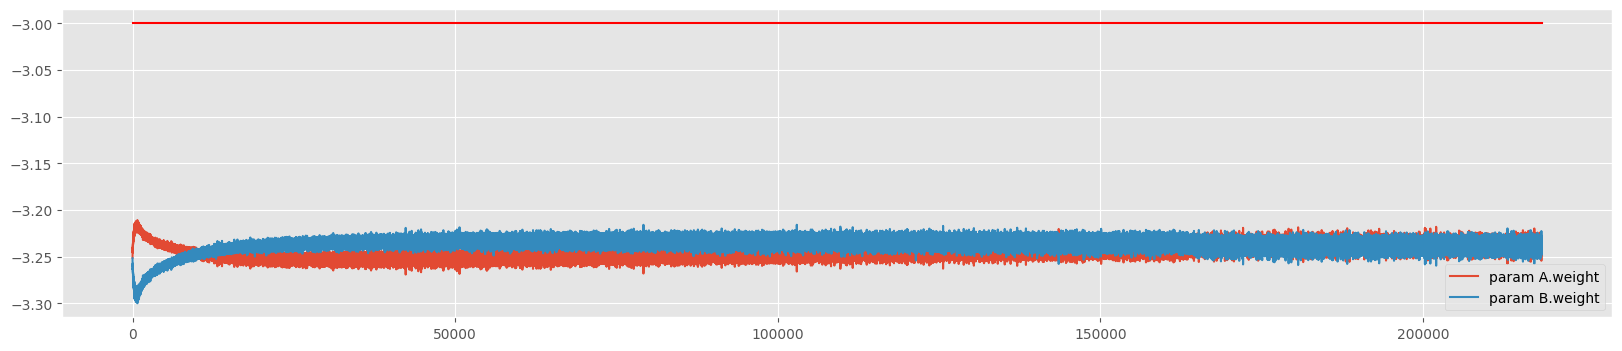

In [ ]:
""" FILL IN"""

How do you make sure the learing rate is good? Look at the above plots and suppose we have $log(LR * ratio) = -5$. Then $LR * ratio = 10^{-5}$. Assuming the ratio does not vary much, this probably means we need to increase the learing rate $LR$. Similarly for a reverse direction.